In [220]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
import random

class optimized_graph(nn.Module):
    def __init__(self, nodes, all_edges):
        super(optimized_graph, self).__init__()
        self.nodes = nodes # list of names
        self.edges = [(edge[0], edge[1]) if edge[2] == "activates" else (edge[0], edge[1]) for edge in all_edges]
        self.reg_state = [edge[2] for edge in all_edges]
        self.weights = nn.Parameter( torch.rand(len(all_edges)) ) # Must be between 0 and 1
        #self.batch_size = batch_size
        self.num_nodes = len(nodes)
        self.node_indices = {node: i for i, node in enumerate(nodes)}
        #self.edge_indices = [{"source":edge[0], "target":edge[1], "action":edge[2]} for edge in edges]
        self.graph = self.build_graph(initial=True)
    
    def build_graph(self, weights = None, initial=False):
        if initial:
            G = nx.DiGraph()
            G.add_nodes_from(self.nodes)
            G.add_edges_from(self.edges)
        else:
            G = self.graph
    
        if weights is None:
            for i, edge in enumerate(self.edges):
                nx.set_edge_attributes(G, {edge: {"weight": self.reg_state[i]}})
        else:
            nx.set_edge_attributes(G, {edge: {"weight": float(sign*weight)} for edge, weight, sign in zip(self.edges, weights, self.reg_state)})
        return G

    @staticmethod
    def initialize_node_states(batch_size, num_nodes):
        return torch.rand(batch_size, num_nodes)
    
    def update_states(self, states, edges, weights, num_iterations=10):
        for _ in range(num_iterations):
            new_states = states.clone()
            for i, (source, target, sign) in enumerate(edges):
                source_idx = self.node_indices[source]
                target_idx = self.node_indices[target]
                new_states[:, target_idx] += sign * weights[i] * states[:, source_idx]
            #states = torch.sigmoid(new_states)
            states = torch.clamp(new_states, 0, 1)
            #print(states)
        return states
        
        
    def optimization(self,edges_dataset, batch_size=2048, steps=1000, early_stop_step=25, verbose=1):
        loss_fn = nn.MSELoss()
        optimizer = optim.Adam([self.weights], lr=1e-2)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1, verbose=True, min_lr=1e-10)
        
        best_loss = 1e3
        early_stop = 0
        best_weights = self.weights.clone()
        
        for step in range(steps):
            loss = 0
            random.shuffle(edges_dataset)
            for edge, target_ratio in edges_dataset:
                #print(target_ratio)
                states = self.initialize_node_states(batch_size, self.num_nodes)
                updated_state = self.update_states(states, edge, self.weights)
                
                states_prob = torch.mean(updated_state[:, 0:2], dim=0)
                loss += loss_fn(states_prob, target_ratio)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            with torch.no_grad():
                self.weights.data = torch.clamp(self.weights, 0.01, 1)
            if verbose:
                assert type(verbose) == int
                if step % verbose == 0: 
                    print(f"step | {step} \t Loss: {loss.item()}")
            #states = updated_state.mean(dim=0).repeat(self.batch_size, 1)
            
            scheduler.step(loss.item())
            
            if loss < best_loss:
                best_loss = loss
                best_weights = self.weights.clone()
                early_stop = 0
            else:
                early_stop += 1
                if early_stop > early_stop_step:
                    break
        print(f"Best Loss: {best_loss.item()}")
        print("Final states", states_prob)
        self.weights.data = best_weights
        self.graph = self.build_graph(weights=best_weights.detach())

In [221]:

# Define nodes
nodes = [
    "CyclinE", "Caspase",
    "Rb", "p53", "ATM", "MDM2", "p21", "PTEN", "CyclinG", "Wip1",
    "BCL2", "Bax", "E2F1", "AKT", "p14ARF", "MdmX",
    "Skp2", "p27"
]
node_indices = {node: i for i, node in enumerate(nodes)}

# Define edges with interactions
edges = [
    ("Rb", "E2F1", "inhibits"),
    ("Rb", "p27", "activates"), ("MDM2", "p53", "inhibits"),  ("MdmX", "p53", "inhibits"), 
    ("CyclinE", "Rb", "inhibits"), 
    ("MDM2", "Rb", "inhibits"), ("Rb", "MDM2", "inhibits"), 
    ("Caspase", "Rb", "inhibits"), ("E2F1", "p14ARF", "activates"), 
    ("E2F1", "Caspase", "activates"), ("p14ARF", "MDM2", "inhibits"), 
    ("p14ARF", "E2F1", "activates"), ("MDM2", "E2F1", "activates"), 
    ("ATM", "Rb", "activates"), ("ATM", "E2F1", "activates"), 
    ("ATM", "AKT", "activates"), ("E2F1", "ATM", "activates"), 
    ("ATM", "CyclinE", "inhibits"), ("E2F1", "CyclinE", "activates"), 
    ("E2F1", "AKT", "activates"), ("MDM2", "MdmX", "inhibits"), 
    ("MdmX", "MDM2", "activates"),
    ("ATM", "MdmX", "inhibits"), ("p14ARF", "MdmX", "inhibits"), 
    ("AKT", "MdmX", "activates"), ("p53", "Wip1", "activates"), 
    ("p53", "CyclinG", "activates"), ("p53", "p21", "activates"), 
    ("p53", "PTEN", "activates"), ("p53", "BCL2", "inhibits"), 
    ("p53", "Bax", "activates"), ("p53", "MDM2", "activates"), 
    ("p53", "p14ARF", "inhibits"), ("ATM", "p53", "activates"), 
    ("ATM", "MDM2", "inhibits"), ("Caspase", "BCL2", "inhibits"), 
    ("p21", "Caspase", "inhibits"), ("p21", "CyclinE", "inhibits"), 
    ("CyclinE", "MDM2", "inhibits"), ("Wip1", "MDM2", "activates"), 
    ("Wip1", "p14ARF", "inhibits"), ("Wip1", "MdmX", "activates"), 
    ("Wip1", "ATM", "inhibits"), ("Wip1", "p53", "inhibits"), 
    ("PTEN", "AKT", "inhibits"), ("AKT", "Bax", "inhibits"), 
    ("E2F1", "BCL2", "inhibits"), ("E2F1", "Bax", "activates"), 
    ("MDM2", "p21", "inhibits"), 
    ("CyclinG", "MDM2", "activates"), ("CyclinG", "ATM", "inhibits"), 
    ("BCL2", "Caspase", "inhibits"), ("BCL2", "Bax", "inhibits"), 
    ("Bax", "Caspase", "activates"), ("E2F1", "p53", "activates"), 
    ("E2F1", "Wip1", "activates"), ("AKT", "MDM2", "activates"), 
    ("AKT", "MdmX", "activates"), ("AKT", "p21", "inhibits"), 
    ("AKT", "BCL2", "activates"), ("AKT", "Caspase", "inhibits"),
    ("Rb", "Skp2", "inhibits"),
    ("Skp2", "p27", "inhibits"),
    ("p27", "CyclinE", "inhibits"),
    ("E2F1", "Skp2", "activates"),
]

edges = [(edge[0], edge[1], 1) if edge[2] == "activates" else (edge[0], edge[1], -1) for edge in edges]
edges1 = edges[1:]
edges2 = edges1[1:]
edges3 = [edges1[0]] + edges1[2:]
edges4 = edges1[0:2] + edges1[3:]

edges_dataset = [
    [edges, torch.Tensor([0.65, 0.07])],
    [edges1, torch.Tensor([0.8, 0.01])],
    [edges, torch.Tensor([0.65, 0.07])],
    [edges2, torch.Tensor([0.1, 0.9])],
    [edges1, torch.Tensor([0.8, 0.01])],
    [edges3, torch.Tensor([0.1, 0.9])],
    [edges4, torch.Tensor([0.1, 0.9])],
    #[edges, torch.Tensor([0.65, 0.07])],
]
all_edges = [(edge[0], edge[1]) for edge in edges]
reg = [edge[2] for edge in edges]

In [222]:
graph = optimized_graph(nodes, edges)
graph.optimization(edges_dataset)

step | 0 	 Loss: 1.234352707862854
step | 1 	 Loss: 0.9491875171661377
step | 2 	 Loss: 0.8087208271026611
step | 3 	 Loss: 0.7026184797286987
step | 4 	 Loss: 0.6253126859664917
step | 5 	 Loss: 0.5774179697036743
step | 6 	 Loss: 0.5131111145019531
step | 7 	 Loss: 0.4514670670032501
step | 8 	 Loss: 0.41454386711120605
step | 9 	 Loss: 0.3640872836112976
step | 10 	 Loss: 0.30761292576789856
step | 11 	 Loss: 0.24184876680374146
step | 12 	 Loss: 0.18219922482967377
step | 13 	 Loss: 0.14710964262485504
step | 14 	 Loss: 0.10839800536632538
step | 15 	 Loss: 0.08468295633792877
step | 16 	 Loss: 0.07540877163410187
step | 17 	 Loss: 0.06944771111011505
step | 18 	 Loss: 0.06268475949764252
step | 19 	 Loss: 0.06039739400148392
step | 20 	 Loss: 0.059673234820365906
step | 21 	 Loss: 0.059076420962810516
step | 22 	 Loss: 0.05918297916650772
step | 23 	 Loss: 0.059820257127285004
step | 24 	 Loss: 0.05968976765871048
step | 25 	 Loss: 0.06013550981879234
step | 26 	 Loss: 0.061254218

In [223]:
graph.graph.edges(data=True)

OutEdgeDataView([('CyclinE', 'Rb', {'weight': -0.8773779273033142}), ('CyclinE', 'MDM2', {'weight': -1.0}), ('Caspase', 'Rb', {'weight': -0.5707048773765564}), ('Caspase', 'BCL2', {'weight': -0.6249424815177917}), ('Rb', 'E2F1', {'weight': -0.9540732502937317}), ('Rb', 'p27', {'weight': 0.6486621499061584}), ('Rb', 'MDM2', {'weight': -0.45056286454200745}), ('Rb', 'Skp2', {'weight': -0.4487302005290985}), ('p53', 'Wip1', {'weight': 0.7426730394363403}), ('p53', 'CyclinG', {'weight': 0.4116882085800171}), ('p53', 'p21', {'weight': 0.7342031598091125}), ('p53', 'PTEN', {'weight': 0.026826422661542892}), ('p53', 'BCL2', {'weight': -0.44991374015808105}), ('p53', 'Bax', {'weight': 0.18317756056785583}), ('p53', 'MDM2', {'weight': 0.1928526610136032}), ('p53', 'p14ARF', {'weight': -0.2184566855430603}), ('ATM', 'Rb', {'weight': 0.7474362254142761}), ('ATM', 'E2F1', {'weight': 0.9785053730010986}), ('ATM', 'AKT', {'weight': 0.8879976272583008}), ('ATM', 'CyclinE', {'weight': -0.9113941788673

# DynNetwork Benchmark

In [224]:
import matplotlib.pyplot as plt
import numpy as np
import random

def initialize_states(G, j):
    binary = format(j, '016b')
    states = {}
    for i, node in enumerate(G.nodes): # random float between 0 and 1
        states[node] = random.uniform(0, 1)
    return np.array(list(states.values()))

# Function to update states based on the interaction
def update_states(G, states, adj):
    new_states = adj @ states + states###########################
    # >1: 1, <0: 0
    new_states = np.where(new_states > 1, 1, new_states)
    new_states = np.where(new_states < 0, 0, new_states)
    return new_states

# Function to run the simulation for a number of steps
def run_simulation(G,j, adj, steps=25):
    states = initialize_states(G, j)
    death_count, proliferate_count = 0,0
    #print(f"Initial states: {states}")
    for step in range(steps):
        states = update_states(G, states, adj)
       #print(f"States at step {step + 1}: {states}")
        if states[node_indices['Caspase']] >= 1:
            death_count += 1
        else:
            death_count = 0
        if states[node_indices["CyclinE"]] >= 1:
            proliferate_count += 1
        
        else:
            proliferate_count = 0
        if death_count >= 5:
            return np.array([1,0,0])
        if proliferate_count >= 10:
            return np.array([0,0,1])
    return np.array([0,1,0])

In [225]:
G = orig_G

sample = 2**11
temp_edges = list(G.edges(data=True)) # Initialize
#temp_edges.append(("Rb", "E2F1", {"action": "inhibits"}),)

num_nodes = len(G.nodes)
state_count = np.array([0,0,0])

adj = np.zeros((num_nodes, num_nodes))

for edge in temp_edges:
    src, dest, action = edge
    action = action['weight']
    src_idx = node_indices[src]
    dest_idx = node_indices[dest]
    adj[dest_idx, src_idx] = action

for j in range(sample):
    state_count += run_simulation(G, j, adj)
print('--------------------------------------------')
print(f"Original Network")
print(state_count)
print((state_count[0]*4 + state_count[1]*2 + state_count[2]*1)/ sample)

--------------------------------------------
Original Network
[550 740 758]
2.1669921875


In [226]:
#orig_G = G.copy()

# Cancer

In [227]:
#G.remove_edge("Rb", "E2F1")
sample = 2**11
temp_edges = list(G.edges(data=True)) # Initialize
#temp_edges.append(("Rb", "E2F1", {"action": "inhibits"}),)

num_nodes = len(G.nodes)
state_count = np.array([0,0,0])

adj = np.zeros((num_nodes, num_nodes))

for edge in temp_edges:
    src, dest, action = edge
    action = action['weight']
    src_idx = node_indices[src]
    dest_idx = node_indices[dest]
    adj[dest_idx, src_idx] = action

for j in range(sample):
    state_count += run_simulation(G, j, adj)
print('--------------------------------------------')
print(f"Original Network")
print(state_count)
print((state_count[0]*4 + state_count[1]*2 + state_count[2]*1)/ sample)

--------------------------------------------
Original Network
[518 765 765]
2.13232421875


In [228]:
#temp_edges = orig_edges
sample = 2**11
results = []
nodes = list(G.nodes)
orig_edges = list(G.edges(data=True))
for i in range(len(orig_edges)):
    temp_edges = orig_edges.copy() # Initialize
    
    rm_edge = temp_edges.pop(i)

    temp_G = nx.DiGraph()
    temp_G.add_nodes_from(nodes)
    temp_G.add_edges_from(temp_edges)
    
    num_nodes = len(nodes)
    state_count = np.array([0,0,0])
    
    adj = np.zeros((num_nodes, num_nodes))
    
    for edge in temp_edges:
        src, dest, action = edge
        action = action['weight']
        src_idx = node_indices[src]
        dest_idx = node_indices[dest]
        adj[dest_idx, src_idx] = action

    for j in range(sample):
        state_count += run_simulation(temp_G, j, adj)
    print('--------------------------------------------')
    print(f"Removed edge: {rm_edge}")
    print(state_count)
    print((state_count[0]*4 + state_count[1]*2 + state_count[2]*1)/ sample)
    results.append((rm_edge[0],rm_edge[1], (state_count[0]*4 + state_count[1]*2 + state_count[2]*1)/ sample ))

--------------------------------------------
Removed edge: ('CyclinE', 'Rb', {'weight': -0.6157497763633728})
[602 762 684]
2.25390625
--------------------------------------------
Removed edge: ('CyclinE', 'MDM2', {'weight': -0.7492326498031616})
[516 742 790]
2.1181640625
--------------------------------------------
Removed edge: ('Caspase', 'Rb', {'weight': -0.4841742515563965})
[577 807 664]
2.2392578125
--------------------------------------------
Removed edge: ('Caspase', 'BCL2', {'weight': -0.0534595362842083})
[543 727 778]
2.150390625
--------------------------------------------
Removed edge: ('Rb', 'p27', {'weight': 0.9084880352020264})
[423 696 929]
1.95947265625
--------------------------------------------
Removed edge: ('Rb', 'MDM2', {'weight': -0.4857763946056366})
[534 741 773]
2.14404296875
--------------------------------------------
Removed edge: ('Rb', 'Skp2', {'weight': -0.8038594126701355})
[540 713 795]
2.13916015625
--------------------------------------------
Rem

In [208]:
nodes

['CyclinE',
 'Caspase',
 'Rb',
 'p53',
 'ATM',
 'MDM2',
 'p21',
 'PTEN',
 'CyclinG',
 'Wip1',
 'BCL2',
 'Bax',
 'E2F1',
 'AKT',
 'p14ARF',
 'MdmX']

In [210]:
orig_edges

[('CyclinE', 'Rb', {'weight': -0.915324330329895}),
 ('CyclinE', 'MDM2', {'weight': -0.5064454078674316}),
 ('Caspase', 'Rb', {'weight': -0.6553428173065186}),
 ('Caspase', 'BCL2', {'weight': -0.7707189321517944}),
 ('Rb', 'MDM2', {'weight': -0.11945982277393341}),
 ('p53', 'Wip1', {'weight': 0.09534616023302078}),
 ('p53', 'CyclinG', {'weight': 0.13994471728801727}),
 ('p53', 'p21', {'weight': 0.3478885591030121}),
 ('p53', 'PTEN', {'weight': 0.009999999776482582}),
 ('p53', 'BCL2', {'weight': -0.43193453550338745}),
 ('p53', 'Bax', {'weight': 0.5266306400299072}),
 ('p53', 'MDM2', {'weight': 0.6150918006896973}),
 ('p53', 'p14ARF', {'weight': -0.16607677936553955}),
 ('ATM', 'Rb', {'weight': 0.601845920085907}),
 ('ATM', 'E2F1', {'weight': 0.4735940098762512}),
 ('ATM', 'AKT', {'weight': 0.8811937570571899}),
 ('ATM', 'CyclinE', {'weight': -0.09586064517498016}),
 ('ATM', 'MdmX', {'weight': -0.009999999776482582}),
 ('ATM', 'p53', {'weight': 0.35706329345703125}),
 ('ATM', 'MDM2', {'

In [232]:
temp_edges = orig_edges
sample = 2**10
for j, rm_node in enumerate(nodes):
    temp_G = nx.DiGraph()
    temp_G.add_nodes_from(nodes)
    temp_G.add_edges_from(temp_edges)
    
    temp_G.remove_node(rm_node)
    
    num_nodes = len(nodes)-1
    state_count = np.array([0,0,0])
    
    adj = np.zeros((num_nodes, num_nodes))
    
    _node_indices = {node: i for i, node in enumerate(temp_G.nodes)}

    for edge in temp_G.edges(data=True):
        src, dest, action = edge
        action = action['weight']
        src_idx = _node_indices[src]
        dest_idx = _node_indices[dest]
        adj[dest_idx, src_idx] = action

    for j in range(sample):
        state_count += run_simulation(temp_G, j, adj)
    print('--------------------------------------------')
    print(f"Removed node: {rm_node}")
    print(state_count)
    print((state_count[0]*4 + state_count[1]*2 + state_count[2]*1)/ sample)

--------------------------------------------
Removed node: CyclinE
[435 291 298]
2.55859375
--------------------------------------------
Removed node: Caspase
[346  76 602]
2.087890625
--------------------------------------------
Removed node: Rb
[210 364 450]
1.970703125
--------------------------------------------
Removed node: p53
[147 479 398]
1.8984375
--------------------------------------------
Removed node: ATM
[661   0 363]
2.9365234375
--------------------------------------------
Removed node: MDM2
[238 512 274]
2.197265625
--------------------------------------------
Removed node: p21
[284 354 386]
2.177734375
--------------------------------------------
Removed node: PTEN
[  0 384 640]
1.375
--------------------------------------------
Removed node: CyclinG
[  14 1010    0]
2.02734375
--------------------------------------------
Removed node: Wip1
[161 660 203]
2.1162109375
--------------------------------------------
Removed node: BCL2
[1024    0    0]
4.0
----------------

In [ ]:
[1.8193359375, 2.7646484375, 2.2177734375, 2.138671875, 2.126953125, 1.4169921875, 2.1162109375, 2.02734375, 1.375, 2.177734375, 2.197265625, 2.9365234375, 1.8984375, 1.970703125, 2.087890625, 2.55859375]

# Node Activation

In [233]:
def act_simulation(G,j, adj, act_gene, _node_indices, steps=25):
    states = initialize_states(G, j)
    death_count, proliferate_count = 0,0
    #print(f"Initial states: {states}")
    for step in range(steps):
        states[_node_indices[act_gene]] = 1
        states = update_states(G, states, adj)
        states[_node_indices[act_gene]] = 1
       #print(f"States at step {step + 1}: {states}")
        if states[node_indices['Caspase']] >= 1:
            death_count += 1
        else:
            death_count = 0
        if states[node_indices["CyclinE"]] >= 1:
            proliferate_count += 1
        
        else:
            proliferate_count = 0
        if death_count >= 5:
            return np.array([1,0,0])
        if proliferate_count >= 10:
            return np.array([0,0,1])
    return np.array([0,1,0])

In [234]:
nodes

['CyclinE',
 'Caspase',
 'Rb',
 'p53',
 'ATM',
 'MDM2',
 'p21',
 'PTEN',
 'CyclinG',
 'Wip1',
 'BCL2',
 'Bax',
 'E2F1',
 'AKT',
 'p14ARF',
 'MdmX',
 'Skp2',
 'p27']

In [235]:
temp_edges = orig_edges
sample = 2**11
for j, act_node in enumerate(nodes):
    
    temp_G = nx.DiGraph()
    temp_G.add_nodes_from(nodes)
    temp_G.add_edges_from(temp_edges)
    
    num_nodes = len(nodes)
    state_count = np.array([0,0,0])
    
    adj = np.zeros((num_nodes, num_nodes))
    
    _node_indices = {node: i for i, node in enumerate(temp_G.nodes)}
    
    for edge in temp_G.edges(data=True):
        src, dest, action = edge
        action = action['weight']
        src_idx = _node_indices[src]
        dest_idx = _node_indices[dest]
        if action == "activates":
            adj[dest_idx, src_idx] = 1
        elif action == "inhibits":
            adj[dest_idx, src_idx] = -1
    
    for j in range(sample):
        state_count += act_simulation(temp_G, j, adj, act_node, _node_indices)
    print('--------------------------------------------')
    print(f"Activated node: {act_node}")
    print(state_count)
    print((state_count[0]*4 + state_count[1]*2 + state_count[2]*1)/ sample)


--------------------------------------------
Activated node: CyclinE
[   0    0 2048]
1.0
--------------------------------------------
Activated node: Caspase
[2048    0    0]
4.0
--------------------------------------------
Activated node: Rb
[   0 2048    0]
2.0
--------------------------------------------
Activated node: p53
[   0 2048    0]
2.0
--------------------------------------------
Activated node: ATM
[   0 2048    0]
2.0
--------------------------------------------
Activated node: MDM2
[   0 2048    0]
2.0
--------------------------------------------
Activated node: p21
[   0 2048    0]
2.0
--------------------------------------------
Activated node: PTEN
[   0 2048    0]
2.0
--------------------------------------------
Activated node: CyclinG
[   0 2048    0]
2.0
--------------------------------------------
Activated node: Wip1
[   0 2048    0]
2.0
--------------------------------------------
Activated node: BCL2
[   0 2048    0]
2.0
---------------------------------------

In [274]:
data = [
    2.01953125,
    2.232421875,
    1.85205078125,
    1.86083984375,
    1.36279296875,
    1.513671875,
    1.46484375,
    1.587890625,
    2.2080078125,
    2.0986328125,
    1.5771484375,
    1.4619140625,
    1.52783203125,
    1.837890625,
    1.5615234375,
    1.6572265625,
    1.537109375,
    1.62451171875,
    1.91650390625,
    2.94482421875,
    1.509765625,
    1.54638671875,
    1.505859375,
    1.55224609375,
    1.5703125,
    2.25390625,
    2.1181640625,
    2.2392578125,
    2.150390625,
    1.95947265625,
    2.14404296875,
    2.13916015625,
    2.16552734375,
    2.1748046875,
    2.140625,
    1.92138671875,
    2.10205078125,
    2.14501953125,
    2.169921875,
    2.1494140625,
    2.0498046875,
    2.24462890625,
    3.15771484375,#
    1.8896484375,
    2.15673828125,
    2.14111328125,
    2.169921875,
    2.40478515625,
    2.43408203125,
    2.14501953125,
    2.154296875,
    1.63134765625,
    2.15283203125,
    2.19580078125,
    1.39404296875,
    2.16748046875,
    2.041015625,
    2.21142578125,
    2.15771484375,
    2.14501953125,
    2.11181640625,
    2.1826171875,
    2.56005859375,#
    2.4287109375,
    1.40478515625,
    2.125,
    2.10791015625,
    2.3564453125,
    2.763671875,#
    2.93603515625,##
    1.80029296875,
    1.49169921875,
    2.16552734375,
    2.1748046875,
    2.5517578125,#
    2.16162109375,
    2.26171875,
    2.1962890625,
    2.15966796875,
    4.0,#
    2.1337890625,
    2.162109375,
    2.13037109375,
    2.16845703125,
    2.2099609375,
    2.17138671875,
    2.72998046875,#
    1.82373046875
]
x1 = 2.1962
x2 = 2.404785
x3 = 2.20996
#('Rb', 'p27' : 2.1962
#MDM2, p53: 2.404785
#MdmX, p53: 2.20996

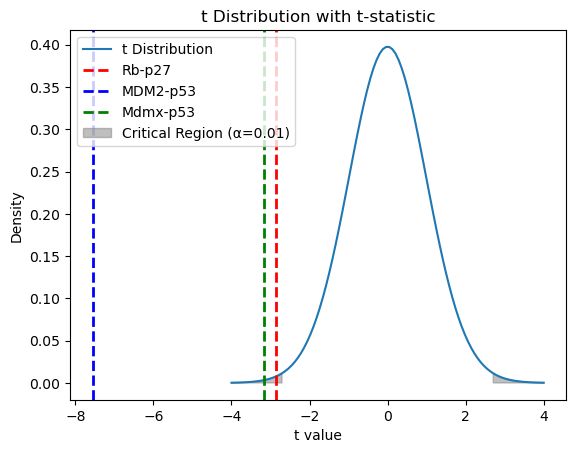

In [275]:
from scipy.stats import ttest_1samp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

# サンプルサイズと自由度
n = len(data)
df1 = n - 1

# t値の範囲を設定
t_values = np.linspace(-4, 4, 100)
# t分布を計算
t_dist = t.pdf(t_values, df1)

# t検定の結果
t_stat1, p_value1 = ttest_1samp(data, x1, alternative='less')
t_stat2, p_value2 = ttest_1samp(data, x2, alternative='less')
t_stat3, p_value3 = ttest_1samp(data, x3, alternative='less')

# 図の作成
plt.plot(t_values, t_dist, label='t Distribution')
plt.axvline(x=t_stat1, color='red', linestyle='dashed', linewidth=2, label=f'Rb-p27')
plt.axvline(x=t_stat2, color='blue', linestyle='dashed', linewidth=2, label=f'MDM2-p53')
plt.axvline(x=t_stat3, color='green', linestyle='dashed', linewidth=2, label=f'Mdmx-p53')

plt.fill_between(t_values, t_dist, where=(t_values > t.ppf(0.995, df1)) | (t_values < t.ppf(0.005, df1)), color='gray', alpha=0.5, label='Critical Region (α=0.01)')
plt.xlabel('t value')
plt.ylabel('Density')
plt.title('t Distribution with t-statistic')
plt.legend()
plt.show()

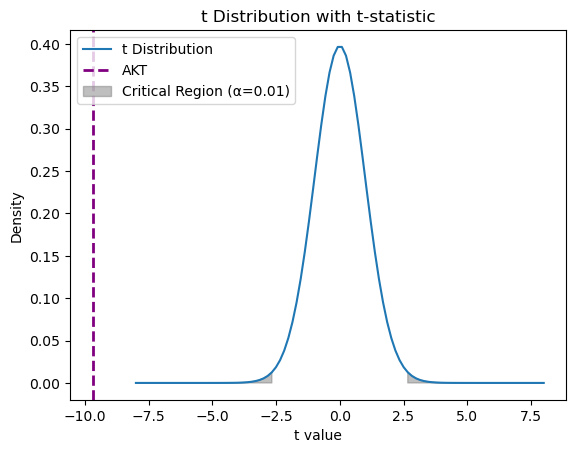

In [276]:
[4, 4, 1.8193359375, 2.7646484375, 2.2177734375, 2.138671875, 2.126953125, 1.4169921875, 2.1162109375, 2.02734375, 1.375, 2.177734375, 2.197265625, 2.9365234375, 1.8984375, 1.970703125, 2.087890625, 2.55859375]
x = 2.5

# サンプルサイズと自由度
n = len(data)
df = n - 1

# t値の範囲を設定
t_values = np.linspace(-8, 8, 100)
# t分布を計算
t_dist = t.pdf(t_values, df)

# t検定の結果
t_stat4, p_value4 = ttest_1samp(data, x, alternative='less')

# 図の作成
plt.plot(t_values, t_dist, label='t Distribution')
plt.axvline(x=t_stat4, color='purple', linestyle='dashed', linewidth=2, label=f'AKT')

plt.fill_between(t_values, t_dist, where=(t_values > t.ppf(0.995, df)) | (t_values < t.ppf(0.005, df)), color='gray', alpha=0.5, label='Critical Region (α=0.01)')
plt.xlabel('t value')
plt.ylabel('Density')
plt.title('t Distribution with t-statistic')
plt.legend()
plt.show()

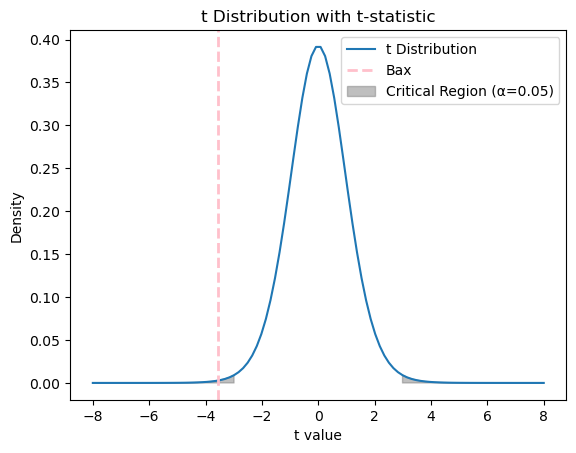

In [277]:
data = [2, 4, 2, 1, 2, 3.9765625, 1.0, 1.0, 1.6875, 4, 1, 1, 1.19140625, 1, 1.0315625, 1.7578125, 2]
x = 2.8125

# サンプルサイズと自由度
n = len(data)
df = n - 1

# t値の範囲を設定
t_values = np.linspace(-8, 8, 100)
# t分布を計算
t_dist = t.pdf(t_values, df)

# t検定の結果
t_stat5, p_value5 = ttest_1samp(data, x, alternative='greater')

# 図の作成
plt.plot(t_values, t_dist, label='t Distribution')
plt.axvline(x=t_stat5, color='pink', linestyle='dashed', linewidth=2, label=f'Bax')

plt.fill_between(t_values, t_dist, where=(t_values > t.ppf(0.995, df)) | (t_values < t.ppf(0.005, df)), color='gray', alpha=0.5, label='Critical Region (α=0.05)')
plt.xlabel('t value')
plt.ylabel('Density')
plt.title('t Distribution with t-statistic')
plt.legend()
plt.show()

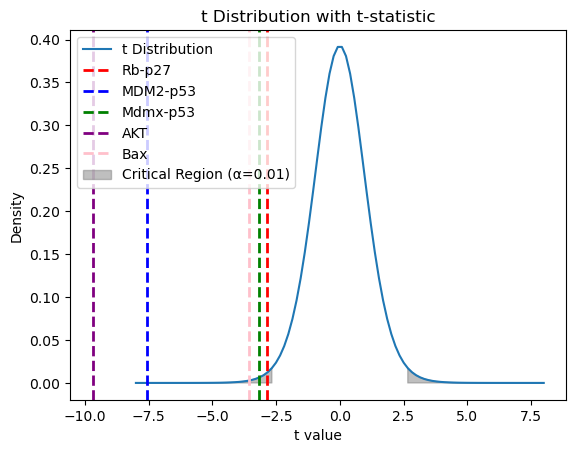

In [278]:
plt.plot(t_values, t_dist, label='t Distribution')
plt.axvline(x=t_stat1, color='red', linestyle='dashed', linewidth=2, label=f'Rb-p27')
plt.axvline(x=t_stat2, color='blue', linestyle='dashed', linewidth=2, label=f'MDM2-p53')
plt.axvline(x=t_stat3, color='green', linestyle='dashed', linewidth=2, label=f'Mdmx-p53')
plt.axvline(x=t_stat4, color='purple', linestyle='dashed', linewidth=2, label=f'AKT')
plt.axvline(x=t_stat5, color='pink', linestyle='dashed', linewidth=2, label=f'Bax')

plt.fill_between(t_values, t_dist, where=(t_values > t.ppf(0.995, df1)) | (t_values < t.ppf(0.005, df1)), color='gray', alpha=0.5, label='Critical Region (α=0.01)')
plt.xlabel('t value')
plt.ylabel('Density')
plt.title('t Distribution with t-statistic')
plt.legend()
plt.show()